# Charts

## Setup

In [43]:
# Import necessary libraries
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os
import pandas as pd


# Define utility functions and classes
class Formula:
    def __init__(self, data_sources):
        self.data_sources = data_sources

    def apply(self):
        raise NotImplementedError("Formula application not implemented.")

def base_plot(config):
    plt.style.use(config['style']['theme'])
    plt.figure(figsize=config['style']['figsize'])

    plt.suptitle(config['title'], color=config['style']['title_color'], fontsize=config['style']['fontsize_title'])
    plt.title(config['subtitle'], color=config['style']['title_color'], fontsize=config['style']['fontsize_subtitle'])

    source_text = f"Source: {config['author']}; {config['source']}"
    copyright_text = f"© {datetime.now().year} Wild Capital LLC"
    plt.text(0.01, 0.01, source_text, transform=plt.gcf().transFigure, color=config['style']['text_color'], fontsize=config['style']['fontsize_source'], ha='left')
    plt.text(0.99, 0.01, copyright_text, transform=plt.gcf().transFigure, color=config['style']['text_color'], fontsize=config['style']['fontsize_source'], ha='right')

def annotate_events(x, y, data, config):
    for date, event in config['events']:
        if isinstance(date, str):
            date = pd.to_datetime(date)
        if date in data[x].values:
            y_value = data[data[x] == date][y].values[0]
            plt.annotate(event,
                         xy=(date, y_value),
                         xytext=(0, 40 if date != pd.to_datetime('2000-01-01') else -60),
                         textcoords='offset points',
                         arrowprops=dict(facecolor='green', shrink=0.05),
                         ha='center', fontsize=config['style']['fontsize_label'], color=config['style']['title_color'],
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='black'))


def add_horizontal_line(y, color='white', linestyle='--', linewidth=1.5, label=None):
    plt.axhline(y=y, color=color, linestyle=linestyle, linewidth=linewidth, label=label)

def plot_data(config, data):
    x = config['x_axis_key']
    y = config['y_axis_key']

    base_plot(config)

    plt.plot(data[x], data[y], color='white', label=y, linewidth=config['style']['data_line_width'])

    add_horizontal_line(y=data[y].quantile(0.9), color='red', label='Historically Overvalued')
    add_horizontal_line(y=data[y].mean(), color='yellow', label='Average')
    add_horizontal_line(y=data[y].quantile(0.1), color='green', label='Historically Undervalued')

    annotate_events(x, y, data, config)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.ylabel('Yield (%)', color='white', fontsize=config['style']['fontsize_label'])
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"chart/{config['output_file_name']}")
    plt.show()


In [44]:
# Define optional helper methods
def find_high_low(data, column, start_date, end_date, find='high'):
    # Filter the data within the specified date range
    filtered_data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]

    # Find the high or low based on user input
    if find == 'high':
        target_value = filtered_data[column].max()
    elif find == 'low':
        target_value = filtered_data[column].min()
    else:
        raise ValueError("Invalid option for 'find'. Use 'high' or 'low'.")

    # Find the date corresponding to the high or low value
    target_date = filtered_data[filtered_data[column] == target_value]['Date'].iloc[0]

    return target_date, target_value


In [45]:
# Initialize directory paths
if not os.path.exists('chart'):
    os.mkdir('chart')


## Formulas

For each formula:

1. ensure cleaned data is loaded
2. define formula and chart configuration
3. initialize both
4. create chart

### Tips

Extract a formula's data frame:

```python
processed_data = formula.apply()
```

Debug the data frame:

```python
processed_data.head()
```

Find a local maxima/minima on the data frame:

```python
column = 'Portfolio Yield'
start_date = '2010-01-01'
end_date = '2023-11-01'
find = 'low'

date, value = find_high_low(processed_data, column, start_date, end_date, find)
print(f"The {find} value is {value} on {date}")
```



In [46]:
# Load cleaned data
sp500_data = pd.read_csv('clean/sp500_earnings_yield.csv')
us10y_data = pd.read_csv('clean/us10y_yield.csv')


### Mixed Yield Formula

Exploring 60/40 S&P500 to US treasury portfolio performance over time.

In [47]:
class MixedYieldFormula(Formula):
    def apply(self):
        # Merge data frames on 'Year' and 'Month'
        combined_data = self.data_sources[0]
        for df in self.data_sources[1:]:
            combined_data = pd.merge(combined_data, df, on=['Year', 'Month'], how='inner')

        # Create a new 'Date' column combining 'Year' and 'Month'
        combined_data['Date'] = pd.to_datetime(combined_data[['Year', 'Month']].assign(DAY=1))

        # Calculate combined portfolio yield
        combined_data['Portfolio Yield'] = 60 * combined_data['Earnings Yield'] + 40 * combined_data['Treasury Yield']

        # Return the combined data frame
        return combined_data

formula = MixedYieldFormula([sp500_data, us10y_data])
data = formula.apply()


#### Chart: The Earnings Yield Cycle of 60/40 Portfolios

[Inspiration](https://twitter.com/TaviCosta/status/1703603538713272827)

Key Takeaway: We could be heading for a mean reversion for traditional portfolios.

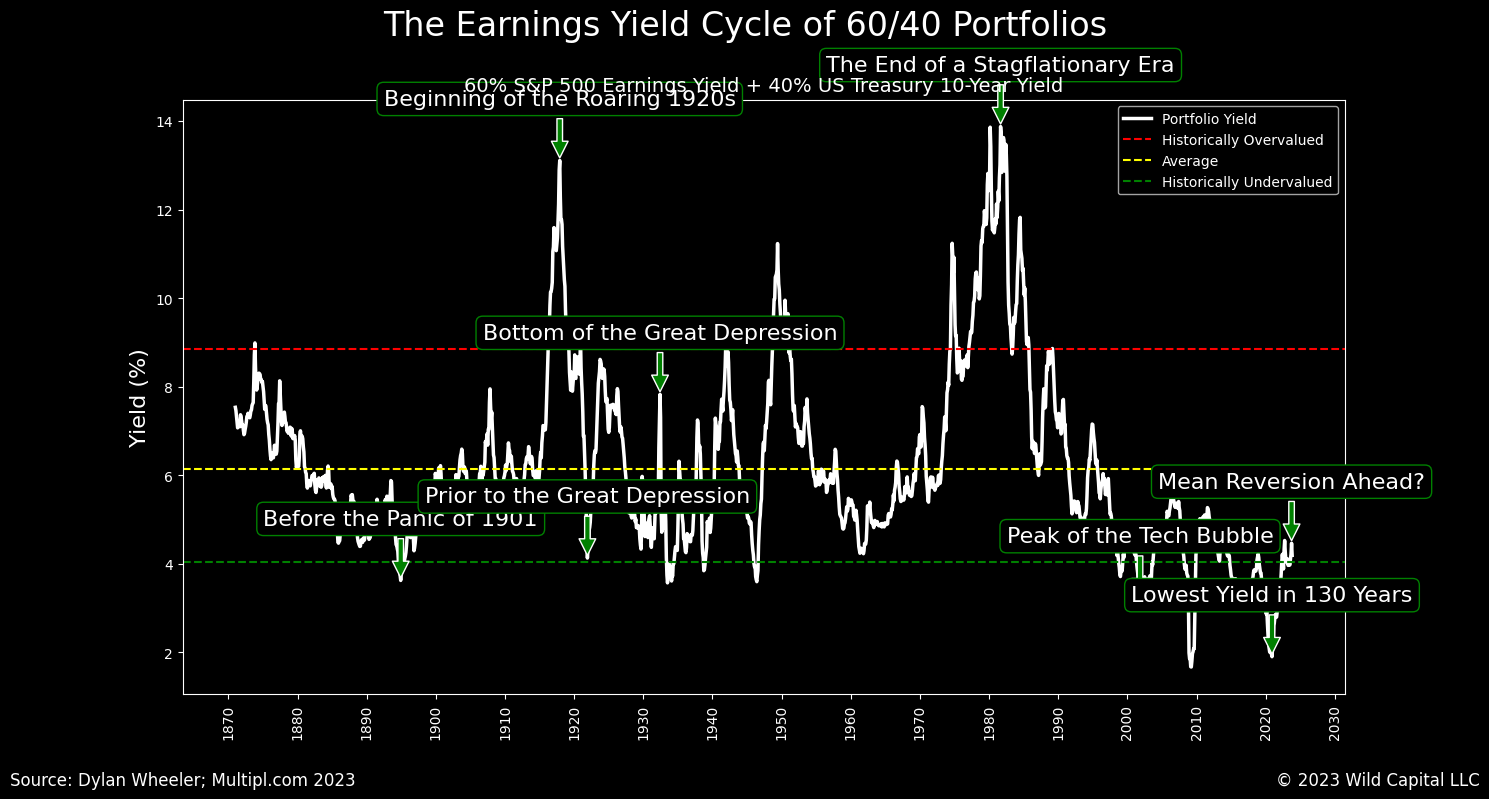

In [49]:
configuration = {
    'author': 'Dylan Wheeler',
    'source': 'Multipl.com 2023',
    'output_file_name': 'earnings_yield_cycle_plot.png',
    'title': 'The Earnings Yield Cycle of 60/40 Portfolios',
    'subtitle': '60% S&P 500 Earnings Yield + 40% US Treasury 10-Year Yield',
    'x_axis_key': 'Date',
    'y_axis_key': 'Portfolio Yield',
    'style': {
        'theme': 'dark_background',
        'figsize': (15, 8),
        'title_color': 'white',
        'text_color': 'white',
        'fontsize_title': 24,
        'fontsize_subtitle': 14,
        'fontsize_source': 12,
        'fontsize_label': 16,
        'data_line_width': 2.5
    },
    'events': [
        ('1894-12-01', 'Before the Panic of 1901'),
        ('1917-12-01', 'Beginning of the Roaring 1920s'),
        ('1921-12-01', 'Prior to the Great Depression'),
        ('1932-06-01', 'Bottom of the Great Depression'),
        ('1981-09-01', 'The End of a Stagflationary Era'),
        ('2001-11-01', 'Peak of the Tech Bubble'),
        ('2020-12-01', 'Lowest Yield in 130 Years'),
        ('2023-10-01', 'Mean Reversion Ahead?')
    ],
}

plot_data(configuration, data)
